In [1]:
import geopandas as gpd
import osmnx as ox
from os import listdir
from shapely.validation import explain_validity, make_valid
import matplotlib.pyplot as plt

# Getting Intermediate Spatial Data

## 1. Getting the Boundary

In [2]:
us_ufa_gdf = gpd.read_file('../data/d01_raw/FUA shapefiles/USA_core_commuting.shx').set_index('fuacode')

<AxesSubplot:>

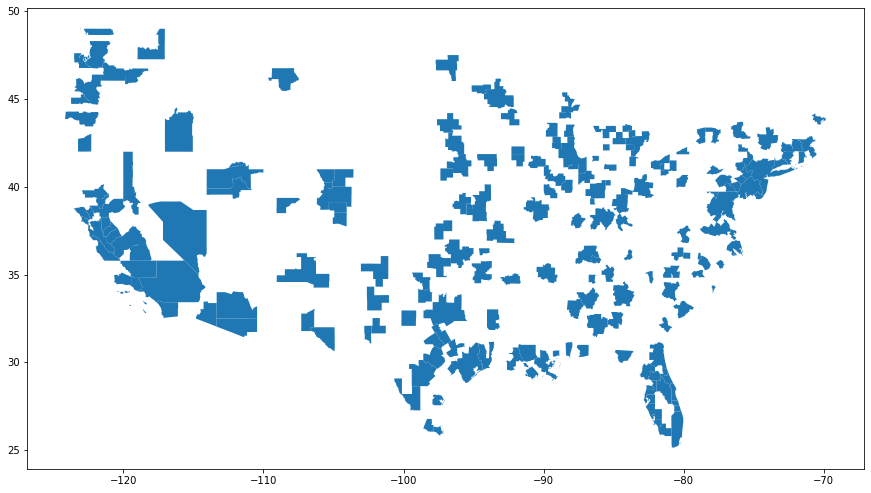

In [3]:
us_ufa_gdf.plot(figsize=(15,10))

We will project it to do the buffer in meters:

In [4]:
us_ufa_proj_gdf = us_ufa_gdf.to_crs('EPSG:5070')

Buffer:

In [5]:
commuting_zone = 10000 #10 km buffer
us_ufa_proj_gdf['geometry'] = us_ufa_proj_gdf['geometry'].buffer(commuting_zone)

Reproject to lat-long in order to get graphs from OSMnx

In [6]:
us_ufa_buffered_gdf = us_ufa_proj_gdf.to_crs('EPSG:4326')

In [7]:
us_ufa_buffered_gdf.head()

,fuaname,geometry
fuacode,,
USA80,Dane,"POLYGON ((-89.96154 43.16780, -89.96164 43.175..."
USA81,Brevard,"POLYGON ((-81.06747 28.66889, -81.06950 28.762..."
USA82,Summit,"POLYGON ((-81.80557 41.24012, -81.80546 41.261..."
USA83,Hamilton (TN),"POLYGON ((-85.97401 35.18395, -85.97744 35.190..."
USA85,Lancaster (PA),"POLYGON ((-76.80940 40.18614, -76.80911 40.186..."


<AxesSubplot:>

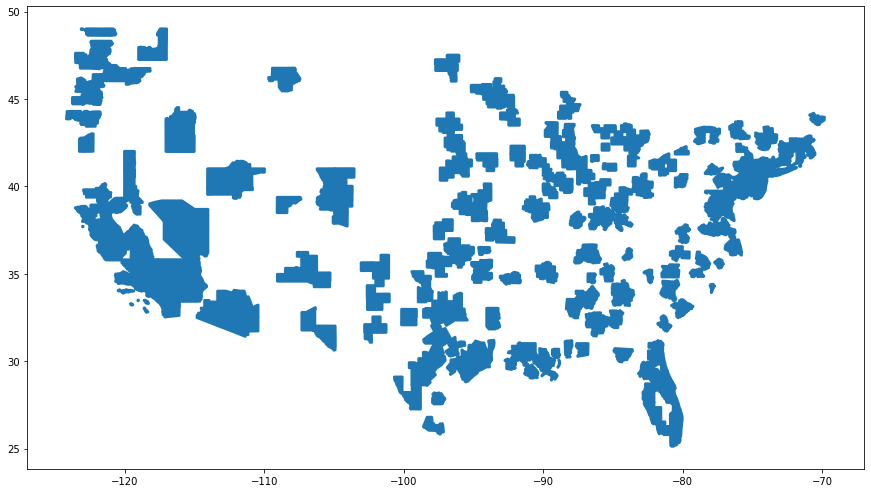

In [8]:
us_ufa_buffered_gdf.plot(figsize=(15,10))

Save buffered geometries as a shapefile:

In [9]:
us_ufa_buffered_gdf.to_file('../data/d03_intermediate/FUA-buffered-shapefile/FUA-buffered.shp')

## 2. Street Networks:

For each (buffered) functional urban area we must collect two street networks from OSMnx: driving and walking. We will save them on two pickled dictionaries whose keys are the FUA codes.

In [10]:
gdf = gpd.read_file('../data/d03_intermediate/FUA-buffered-shapefile/FUA-buffered.shp').set_index('fuacode')
fua_codes = gdf.index.values
fua_buffered_boundaries = gdf.geometry.values

Define a few functions so that we can save the work and pick it up again:

In [11]:
def save_graph(graph_name, boundary, graph_type='walk'):
    #Get the graph
    graph = ox.graph_from_polygon(boundary, network_type=graph_type)
    #Get the filename
    filepath = '../data/d03_intermediate/FUA-networks/' + graph_type + '/' + graph_name + '.graphml'
    #Save the graph
    ox.save_graphml(graph, filepath=filepath)
    return graph

Walk and then drive networks. THIS STEP SHOULD BE DONE WITH MORE CPUs ACCORDING TO THE SCRIPT GET-GRAPHS

In [ ]:
for code, bdry in zip(fua_codes, fua_buffered_boundaries):
    g1 = save_graph(code, bdry, 'walk')
    g2 = save_graph(code, bdry, 'drive')

## 3. Getting Networks that the Cluster could not do:

Found an issue in a few networks (runtime probably). We could run the script again in the cluster, but it also works locally:

In [12]:
gdf = gpd.read_file('../data/d03_intermediate/FUA-buffered-shapefile/FUA-buffered.shp').set_index('fuacode')
fua_codes = gdf.index.values
fua_buffered_boundaries = gdf.geometry.values

saved_drive_networks = [f[:-8] for f in listdir('../data/d03_intermediate/FUA-networks/drive/')]
saved_walk_networks = [f[:-8] for f in listdir('../data/d03_intermediate/FUA-networks/walk/')]

Check which FUAs are missing:

In [13]:
missing_walk, missing_drive = [], []

for fua_code, bdry in zip(fua_codes, fua_buffered_boundaries):
        
    if fua_code not in saved_drive_networks:
        missing_drive.append((fua_code, bdry))
    
    if fua_code not in saved_walk_networks:
        missing_walk.append((fua_code, bdry))

print('Missing drive networks: ', ' and '.join(list(zip(*missing_drive))[0]))
print('Missing walk networks: ', ' and '.join(list(zip(*missing_walk))[0]))
    

Missing drive networks:  USA56
Missing walk networks:  USA56


## 4. Visualizing the Problematic one:

As ntoed above, we could not find the networks for USA56. That is Rochester. Let's see what is happening:

In [14]:
row = gdf.loc[gdf.index == 'USA56']
poly = row.geometry[0]

<AxesSubplot:>

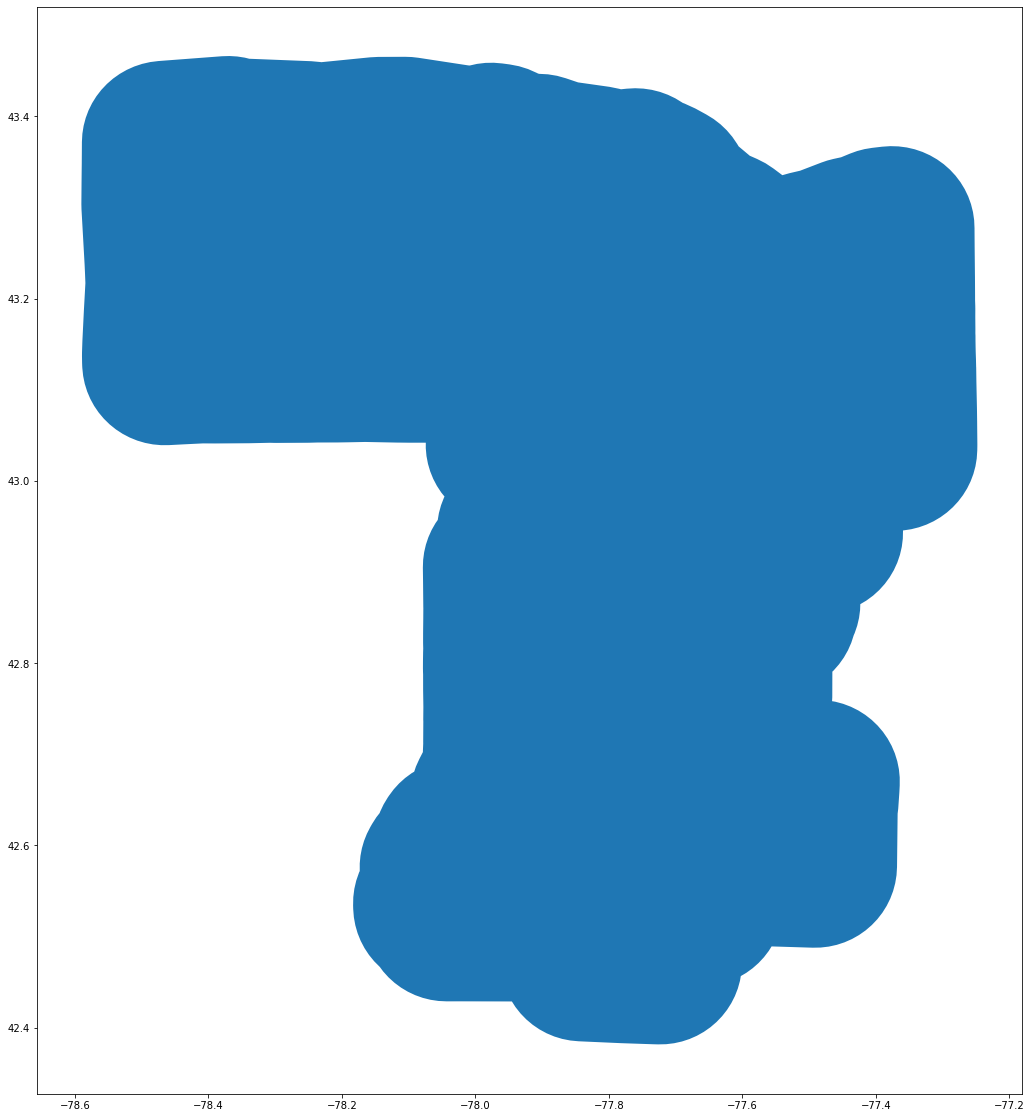

In [15]:
row.plot(figsize=(20,20))

In [16]:
g_drive = ox.graph_from_polygon(poly, network_type='drive')

ValueError: The geometry to query within is invalid

As it is, the geometry is invalid. This means there may be some self intersection or unconnected node:

In [17]:
poly.geom_type

'Polygon'

In [18]:
poly.is_valid

False

In [19]:
explain_validity(poly)

'Self-intersection[-78.1050074754542 43.4652054878552]'

In [20]:
valid_poly = make_valid(poly)

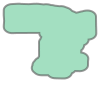

In [21]:
valid_poly

With shapely.validation.make_valid function we were able to produce a valid geometry. Now we can use osmnx to get the graphs:

In [22]:
g_drive = ox.graph_from_polygon(valid_poly, network_type='drive') 
g_walk = ox.graph_from_polygon(valid_poly, network_type='walk') 

/Users/gsagostini/opt/anaconda3/envs/amenities-distance/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/gsagostini/opt/anaconda3/envs/amenities-distance/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/gsagostini/opt/anaconda3/envs/amenities-distance/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/g

Visualizing them on the original (invalid) boundary just to make sure they look ok:

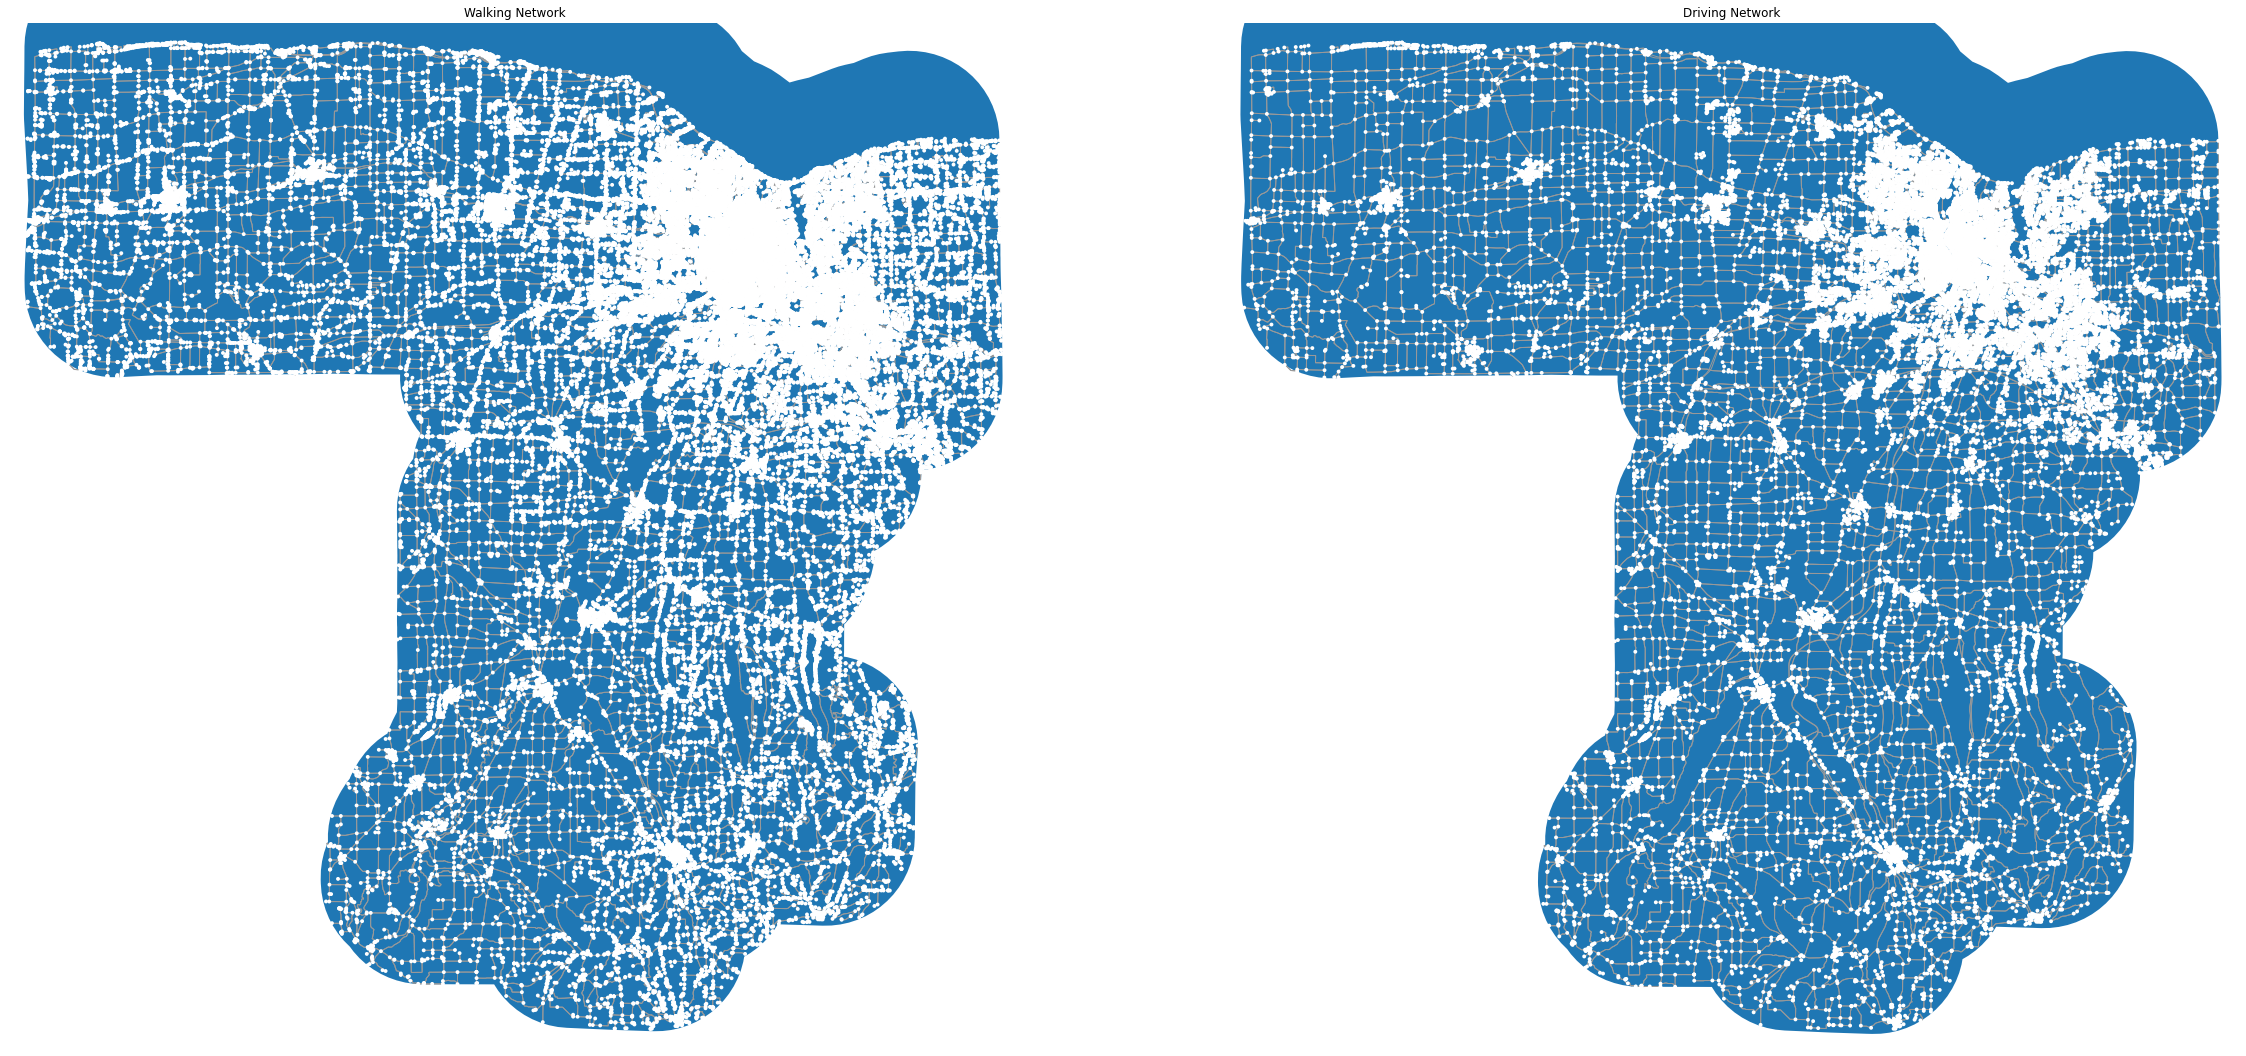

In [23]:
fig, Axes = plt.subplots(figsize=(40,20), ncols=2)

ax1 = row.plot(ax=Axes[0])
ax1 = ox.plot_graph(g_walk, ax=ax1, close=False, show=False)[1]
ax1.title.set_text('Walking Network')

ax2 = row.plot(ax=Axes[1])
ax2 = ox.plot_graph(g_drive, ax=ax2, close=False, show=False)[1]
ax2.title.set_text('Driving Network')

plt.show()

On to saving them and all networks are good to go!

In [24]:
ox.save_graphml(g_walk, filepath='../data/d03_intermediate/FUA-networks/walk/USA56.graphml')
ox.save_graphml(g_drive, filepath='../data/d03_intermediate/FUA-networks/drive/USA56.graphml')